In [4]:
import warnings
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional
import matplotlib.ticker as ticker

# custom
import torch
import os
import glob
from collections import defaultdict


def tree():
    return defaultdict(tree)


import sys

sys.path.append(os.path.abspath("../../"))  # Adjust if needed to make `src` importable
from src.utils.plots_utils import hist_weights_plot, hist_line, compute_hist_data, Line


TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLOR_orange = "darkorange"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "GNN": NN_COLOR_orange,
}
rect = (0.135, 0.18, 0.96, 0.96)
rect_both_axes = (0.14, 0.17, 0.845, 0.96)
figsize = (6, 4.5)

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

linewidth = 2.0


@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    linewidth: Optional[float] = 1.0
    fill: bool = False
    vline: bool = False
    alpha: float = 1.0
    linewidth: float = 2.0


def load(path: str, name: str):
    """
    Loads the model, preprocessing, optimizer and losses.

    Args:
        name: File name for the model (without path and extension)
    """
    state_dict_attrs = ["net", "optimizer", "scheduler"]
    file = os.path.join(path, f"{name}.pth")
    state_dicts = torch.load(file)
    losses = state_dicts["losses"]
    return losses
    # for attr in state_dict_attrs:
    #     try:
    #         getattr(self, attr).load_state_dict(state_dicts[attr])
    #     except AttributeError:
    #         pass

# Physics utils

In [2]:
minkowski = torch.diag(torch.tensor([1.0, -1.0, -1.0, -1.0], dtype=torch.float16))


# compute the scalar product between pairs of the first 10 4-vectors
def covariant2(p1: torch.Tensor, p2: torch.Tensor, keepdim: bool = False) -> torch.Tensor:
    """
    Minkowski inner product of two 4-vectors.
    """
    assert p1.shape == p2.shape and p1.shape[-1] == 4
    assert p1.dtype == p2.dtype

    g = torch.tensor([1.0, -1.0, -1.0, -1.0], dtype=p1.dtype, device=p1.device)

    out = torch.sum(p1 * g * p2, dim=-1, keepdim=keepdim)
    return out


def delta_r(
    p: torch.Tensor,
    eta1: torch.Tensor,
    eta2: torch.Tensor,
    phi1: torch.Tensor,
    phi2: torch.Tensor,
) -> torch.Tensor:
    deta = delta_eta(p, eta1, eta2)
    dphi = delta_phi(p, phi1, phi2)
    return torch.sqrt(deta**2 + dphi**2)


def delta_eta(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    deta = eta1 - eta2
    return torch.abs(deta) if abs else deta


def delta_phi(
    p: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    dphi = phi1 - phi2
    dphi = (dphi + torch.pi) % (2 * torch.pi) - torch.pi
    return torch.abs(dphi) if abs else dphi


def LorentzProduct(p1, p2, base="EPxPyPz"):
    if base == "PtPhiEtaM":
        p1 = PtPhiEtaM_to_EPxPyPz(p1)
        p2 = PtPhiEtaM_to_EPxPyPz(p2)
    elif base == "EPxPyPz":
        pass
    else:
        raise ValueError(f"Base {base} not recognised")
    return p1[..., 0] * p2[..., 0] - torch.sum(p1[..., 1:] * p2[..., 1:], axis=-1)


def invariant_mass(list_of_p, base="EPxPyPz"):
    """
    list of p is a list of tensors of shape (N, 4) or (N, 3)
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        stacked = torch.stack(list_of_p, axis=1)  # shape (batch, n_particles, 4)
        summed = stacked.sum(axis=1)  # shape (batch, 4)
        return torch.sqrt(summed[..., 0] ** 2 - torch.sum(summed[..., 1:] ** 2, axis=-1))

    else:
        raise ValueError(f"Base {base} not recognised")


def mandelstam(p1, p2, p3=None, p4=None, p5=None, p6=None, p7=None, base="EPxPyPz"):
    """
    Mandelstam variable s = (p1 + p2)^2
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        sqrts = p1 + p2
        if p3 is not None:
            sqrts += p3
        if p4 is not None:
            sqrts += p4
        if p5 is not None:
            sqrts += p5
        if p6 is not None:
            sqrts += p6
        if p7 is not None:
            sqrts += p7
        sqrtt = p1 - p2
        s = covariant2(sqrts, sqrts)
        t = covariant2(sqrtt, sqrtt)
        return s, t

    else:
        raise ValueError(f"Base {base} not recognised")


def PtPhiEtaM_to_EPxPyPz(PtPhiEtaM, cutoff=10):
    if PtPhiEtaM.shape[-1] == 4:
        pt, phi, eta, mass = PtPhiEtaM[:, torch.arange(4)].T
    elif PtPhiEtaM.shape[-1] == 3:
        pt, phi, eta = PtPhiEtaM[:, torch.arange(3)].T
        mass = torch.zeros_like(pt)  # mass is neglected
    else:
        raise ValueError(f"PtPhiEtaM has wrong shape {PtPhiEtaM.shape}")

    px = pt * torch.cos(phi)
    py = pt * torch.sin(phi)
    pz = pt * torch.sinh(torch.clip(eta, -cutoff, cutoff))
    E = torch.sqrt(mass**2 + px**2 + py**2 + pz**2)

    EPxPyPz = torch.stack((E, px, py, pz), axis=-1)
    assert torch.isfinite(
        EPxPyPz
    ).all(), f"{torch.isnan(EPxPyPz).sum(axis=0)} {torch.isinf(EPxPyPz).sum(axis=0)}"
    return EPxPyPz


def EPxPyPz_to_PtPhiEtaM(EPxPyPz):
    pt = get_pt(EPxPyPz)
    phi = get_phi(EPxPyPz)
    eta = get_eta(EPxPyPz)
    mass = get_mass(EPxPyPz)

    PtPhiEtaM = torch.stack((pt, phi, eta, mass), axis=-1)
    assert torch.isfinite(
        PtPhiEtaM
    ).all(), f"{torch.isnan(PtPhiEtaM).sum(axis=0)} {torch.isinf(PtPhiEtaM).sum(axis=0)}"
    return PtPhiEtaM


def get_pt(particle):
    return torch.sqrt(particle[..., 1] ** 2 + particle[..., 2] ** 2)


def get_phi(particle):
    return torch.arctan2(particle[..., 2], particle[..., 1])


def get_eta(particle, eps=1e-10):
    # eta = torch.arctanh(particle[...,3] / p_abs) # numerically unstable
    p_abs = torch.sqrt(torch.sum(particle[..., 1:] ** 2, axis=-1))
    eta = 0.5 * (
        torch.log(torch.clip(torch.abs(p_abs + particle[..., 3]), eps, None))
        - torch.log(torch.clip(torch.abs(p_abs - particle[..., 3]), eps, None))
    )
    return eta


def get_mass(particle, eps=1e-6):
    return torch.sqrt(
        torch.clip(
            particle[..., 0] ** 2 - torch.sum(particle[..., 1:] ** 2, axis=-1),
            eps,
            None,
        )
    )

# Plots

## HET vs MSE

In [8]:
gg_4g_files = [
    "results/MLP/0708_153349-HET-FC-long",
    "results/MLP/0708_153354-HET-r-long",
    "results/MLP/0708_153411-MSE-FC-long",
    "results/MLP/0708_153411-MSE-r-long",
]
gg_5g_files = [
    "results/MLP/0708_175954-5g-HET-FC-long",
    "results/MLP/0708_180012-5g-HET-r-long",
    "results/MLP/0708_182106-5g-MSE-r-long",
    "results/MLP/0708_182601-5g-MSE-FC-long",
]

In [9]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_4g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins": data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                "ratios-bins": data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")

Successfully loaded data from ../../results/MLP/0708_153349-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-r-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [10]:
with PdfPages(f"figs/new_dataset/gg_4g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["targets-truth_line"],
            results["AFC-MSE"]["targets-NN_line"],
            results["AFC-HET"]["targets-NN_line"],
        ],
        bins=results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins=results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins=results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["deltas_abs-lines"],
            results["AFC-HET"]["deltas_abs-lines"],
        ],
        bins=results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [11]:
with PdfPages(f"figs/new_dataset/gg_4g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["targets-truth_line"],
            results["r-MSE"]["targets-NN_line"],
            results["r-HET"]["targets-NN_line"],
        ],
        bins=results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins=results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins=results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["deltas_abs-lines"],
            results["r-HET"]["deltas_abs-lines"],
        ],
        bins=results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [12]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_5g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins": data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                "ratios-bins": data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")

Successfully loaded data from ../../results/MLP/0708_175954-5g-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_180012-5g-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182106-5g-MSE-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182601-5g-MSE-FC-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [13]:
with PdfPages(f"figs/new_dataset/gg_5g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["targets-truth_line"],
            results["AFC-MSE"]["targets-NN_line"],
            results["AFC-HET"]["targets-NN_line"],
        ],
        bins=results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins=results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins=results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["deltas_abs-lines"],
            results["AFC-HET"]["deltas_abs-lines"],
        ],
        bins=results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [14]:
with PdfPages(f"figs/new_dataset/gg_5g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["targets-truth_line"],
            results["r-MSE"]["targets-NN_line"],
            results["r-HET"]["targets-NN_line"],
        ],
        bins=results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins=results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins=results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["deltas_abs-lines"],
            results["r-HET"]["deltas_abs-lines"],
        ],
        bins=results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

## Regression plots

### LC vs FC surrogate vs r surrogate

In [6]:
# FCvsrLC = "../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/FCvsrLC_tst.pkl"
FC = "../../results/MLP/0717_220809-FC-gg_4g-mse/pkl/factors_tst.pkl"
r = "../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/factors_tst.pkl"

momentaFC = np.load(
    "/remote/gpu02/marino/data/gg_ng/events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy"
)[:, -1]
momentaLC = np.load(
    "/remote/gpu02/marino/data/gg_ng/events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy"
)[:, -3]

tst_slice = int(1e6 * 0.3)
trn_slice = int(1e6 * 0.6)
momentaFC = momentaFC[trn_slice : trn_slice + tst_slice]
momentaLC = momentaLC[trn_slice : trn_slice + tst_slice]

delta_1 = np.abs(momentaFC - momentaLC) / momentaFC

with open(FC, "rb") as f:
    lines_FC = pickle.load(f)
with open(r, "rb") as f:
    lines_r = pickle.load(f)

In [ ]:
y_delta_1, y_delta_1_err = compute_hist_data(
    np.logspace(-14, 4, 64), delta_1, bayesian=False
)
line_delta = Line(
    y=y_delta_1,
    y_err=y_delta_1_err,
    label=r"$\mathcal{A}_{\text{LC}}$",
    color="forestgreen",
)
lines_r[3]["deltas_abs-lines"][0].label = r"$r$ surrogate"
lines_FC[3]["deltas_abs-lines"][0].color = "darkblue"
with PdfPages(f"figs/new_dataset/regression/closure_test-gg_4g-alt.pdf") as pp:
    # assert np.all(
    #     lines_FCvsrLC[3]["ampl-deltas_abs-bins"] == lines_FC[3]["deltas_abs-bins"]
    # )
    # lines_FCvsrLC[3]["ampl-deltas_abs-lines"][
    #     0
    # ].label = r"$r^{\text{pred}} \cdot \mathcal{A}_{\text{LC}}$"
    # lines_FCvsrLC[3]["ampl-deltas_abs-lines"][0].color = NN_COLORS["Transformer"]
    lines_FC[3]["deltas_abs-lines"][0].label = r"$\mathcal{A}_{\text{FC}}$ surrogate"
    hist_weights_plot(
        pp,
        lines=[
            lines_FC[3]["deltas_abs-lines"][0],
            lines_r[3]["deltas_abs-lines"][0],
            line_delta,
        ],
        bins=lines_FC[3]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|\Delta|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        legend_kwargs={"loc": "center left"},
    )

### Histograms

In [5]:
gg_4g_files = [
    "results/MLP/cpu-evald/0817_014119-r-gg_4g",
    "results/GNN/cpu-evald/0817_053309-r-gg_4g",
    "results/Transformer/cpu-evald/0817_044158-r-gg_4g",
    "results/LGATr/cpu-evald/0817_052822-r-gg_4g",
]

gg_5g_files = [
    "results/MLP/cpu-evald/0817_014119-r-gg_5g",
    "results/GNN/cpu-evald/0817_055541-r-gg_5g",
    "results/Transformer/cpu-evald/0817_050243-r-gg_5g",
    "results/LGATr/cpu-evald/0817_071523-r-gg_5g",
]

gg_6g_files = [
    "results/MLP/cpu-evald/0817_014119-r-gg_6g",
    "results/GNN/cpu-evald/0817_063411-r-gg_6g",
    "results/Transformer/cpu-evald/0817_051839-r-gg_6g",
    "results/LGATr/cpu-evald/0817_114313-r-gg_6g",
]

gg_7g_files = [
    "results/MLP/cpu-evald/0817_014119-r-gg_7g",
    "results/GNN/cpu-evald/0817_064714-r-gg_7g",
    "results/Transformer/cpu-evald/0817_052852-r-gg_7g",
    "results/LGATr/cpu-evald/0817_165927-r-gg_7g",
]

gg_ddbar2g_files = [
    "results/MLP/cpu-evald/0817_014255-r-gg_ddbar2g",
    "results/GNN/cpu-evald/0817_031614-r-gg_ddbar2g",
    "results/Transformer/cpu-evald/0817_015529-r-gg_ddbar2g",
    "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar2g",
]

gg_ddbar3g_files = [
    "results/MLP/cpu-evald/0817_014255-r-gg_ddbar3g",
    "results/GNN/cpu-evald/0817_033426-r-gg_ddbar3g",
    "results/Transformer/cpu-evald/0817_021044-r-gg_ddbar3g",
    "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar3g",
]

gg_ddbar4g_files = [
    "results/MLP/cpu-evald/0817_014255-r-gg_ddbar4g",
    "results/GNN/cpu-evald/0817_034355-r-gg_ddbar4g",
    "results/Transformer/cpu-evald/0817_021737-r-gg_ddbar4g",
    "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar4g",
]

gg_ddbar5g_files = [
    "results/MLP/cpu-evald/0817_014255-r-gg_ddbar5g",
    "results/GNN/cpu-evald/0817_041716-r-gg_ddbar5g",
    "results/Transformer/cpu-evald/0817_031608-r-gg_ddbar5g",
    "results/LGATr/cpu-evald/0817_032336-r-gg_ddbar5g",
]

dbard_4g_files = [
    "results/MLP/cpu-evald/0818_201052-r-dbard_4g",
    "results/GNN/cpu-evald/0818_194618-r-dbard_4g",
    "results/Transformer/cpu-evald/0818_194614-r-dbard_4g",
    "results/LGATr/cpu-evald/0819_004025-r-dbard_4g",
]

dbard_5g_files = [
    "results/MLP/cpu-evald/0818_195259-r-dbard_5g",
    "results/GNN/cpu-evald/0818_194617-r-dbard_5g",
    "results/Transformer/cpu-evald/0818_194618-r-dbard_5g",
    "results/LGATr/cpu-evald/0818_194744-r-dbard_5g",
]

dbard_6g_files = [
    "results/MLP/cpu-evald/0818_200236-r-dbard_6g",
    "results/GNN/cpu-evald/0818_194617-r-dbard_6g",
    "results/Transformer/cpu-evald/0818_194618-r-dbard_6g",
    "results/LGATr/cpu-evald/0818_194758-r-dbard_6g",
]

dbard_7g_files = [
    "results/MLP/cpu-evald/0818_200300-r-dbard_7g",
    "results/GNN/cpu-evald/0818_194620-r-dbard_7g",
    "results/Transformer/cpu-evald/0818_194618-r-dbard_7g",
    "results/LGATr/cpu-evald/0818_234153-r-dbard_7g",
]

gg_ddbaruubar0g_co1_files = [
    "results/MLP/cpu-evald/0822_202057-r-gg_ddbaruubar0g_co1",
    "results/GNN/cpu-evald/0823_020947-r-gg_ddbaruubar0g_co1",
    "results/Transformer/cpu-evald/0822_231528-r-gg_ddbaruubar0g_co1",
    "results/LGATr/cpu-evald/0822_170457-r-gg_ddbaruubar0g_co1",
]

gg_ddbaruubar1g_co1_files = [
    "results/MLP/cpu-evald/0822_210534-r-gg_ddbaruubar1g_co1",
    "results/GNN/cpu-evald/0823_024333-r-gg_ddbaruubar1g_co1",
    "results/Transformer/cpu-evald/0822_234207-r-gg_ddbaruubar1g_co1",
    "results/LGATr/cpu-evald/0822_170457-r-gg_ddbaruubar1g_co1",
]

gg_ddbaruubar2g_co1_files = [
    "results/MLP/cpu-evald/0822_221213-r-gg_ddbaruubar2g_co1",
    "results/GNN/cpu-evald/0823_024357-r-gg_ddbaruubar2g_co1",
    "results/Transformer/cpu-evald/0823_011208-r-gg_ddbaruubar2g_co1",
    "results/LGATr/cpu-evald/0822_211704-r-gg_ddbaruubar2g_co1",
]

gg_ddbaruubar3g_co1_files = [
    "results/MLP/cpu-evald/0822_225615-r-gg_ddbaruubar3g_co1",
    "results/GNN/cpu-evald/0823_032114-r-gg_ddbaruubar3g_co1",
    "results/Transformer/cpu-evald/0823_020001-r-gg_ddbaruubar3g_co1",
    "results/LGATr/cpu-evald/0823_000417-r-gg_ddbaruubar3g_co1",
]

gg_ddbaruubar0g_co2_files = [
    "results/MLP/cpu-evald/0823_032114-r-gg_ddbaruubar0g_co2",
    "results/GNN/cpu-evald/0823_070659-r-gg_ddbaruubar0g_co2",
    "results/Transformer/cpu-evald/0823_042528-r-gg_ddbaruubar0g_co2",
    "results/LGATr/cpu-evald/0823_002503-r-gg_ddbaruubar0g_co2",
]

gg_ddbaruubar1g_co2_files = [
    "results/MLP/cpu-evald/0823_033605-r-gg_ddbaruubar1g_co2",
    "results/GNN/cpu-evald/0823_071851-r-gg_ddbaruubar1g_co2",
    "results/Transformer/cpu-evald/0823_043548-r-gg_ddbaruubar1g_co2",
    "results/LGATr/cpu-evald/0823_025411-r-gg_ddbaruubar1g_co2",
]

gg_ddbaruubar2g_co2_files = [
    "results/MLP/cpu-evald/0823_041903-r-gg_ddbaruubar2g_co2",
    "results/GNN/cpu-evald/0823_071953-r-gg_ddbaruubar2g_co2",
    "results/Transformer/cpu-evald/0823_045612-r-gg_ddbaruubar2g_co2",
    "results/LGATr/cpu-evald/0823_032249-r-gg_ddbaruubar2g_co2",
]

gg_ddbaruubar3g_co2_files = [
    "results/MLP/cpu-evald/0823_041906-r-gg_ddbaruubar3g_co2",
    "results/GNN/cpu-evald/0823_073720-r-gg_ddbaruubar3g_co2",
    "results/Transformer/cpu-evald/0823_050315-r-gg_ddbaruubar3g_co2",
    "results/LGATr/cpu-evald/0823_035726-r-gg_ddbaruubar3g_co2",
]

ddbar_uubar2g_co1_files = [
    "results/MLP/cpu-evald/0823_080837-r-ddbar_uubar2g_co1",
    "results/GNN/cpu-evald/0823_094836-r-ddbar_uubar2g_co1",
    "results/Transformer/cpu-evald/0823_090138-r-ddbar_uubar2g_co1",
    "results/LGATr/cpu-evald/0823_073227-r-ddbar_uubar2g_co1",
]

ddbar_uubar3g_co1_files = [
    "results/MLP/cpu-evald/0823_083342-r-ddbar_uubar3g_co1",
    "results/GNN/cpu-evald/0823_095051-r-ddbar_uubar3g_co1",
    "results/Transformer/cpu-evald/0823_091523-r-ddbar_uubar3g_co1",
    "results/LGATr/cpu-evald/0823_080954-r-ddbar_uubar3g_co1",
]

ddbar_uubar4g_co1_files = [
    "results/MLP/cpu-evald/0823_083837-r-ddbar_uubar4g_co1",
    "results/GNN/cpu-evald/0823_100307-r-ddbar_uubar4g_co1",
    "results/Transformer/cpu-evald/0823_093438-r-ddbar_uubar4g_co1",
    "results/LGATr/cpu-evald/0823_085208-r-ddbar_uubar4g_co1",
]

ddbar_uubar5g_co1_files = [
    "results/MLP/cpu-evald/0823_085934-r-ddbar_uubar5g_co1",
    "results/GNN/cpu-evald/0823_102344-r-ddbar_uubar5g_co1",
    "results/Transformer/cpu-evald/0823_093946-r-ddbar_uubar5g_co1",
    "results/LGATr/cpu-evald/0823_131457-r-ddbar_uubar5g_co1",
]

ddbar_uubar2g_co2_files = [
    "results/MLP/cpu-evald/0823_103353-r-ddbar_uubar2g_co2",
    "results/GNN/cpu-evald/0823_124535-r-ddbar_uubar2g_co2",
    "results/Transformer/cpu-evald/0823_115340-r-ddbar_uubar2g_co2",
    "results/LGATr/cpu-evald/0823_195346-r-ddbar_uubar2g_co2",
]

ddbar_uubar3g_co2_files = [
    "results/MLP/cpu-evald/0823_104511-r-ddbar_uubar3g_co2",
    "results/GNN/cpu-evald/0823_130119-r-ddbar_uubar3g_co2",
    "results/Transformer/cpu-evald/0823_121811-r-ddbar_uubar3g_co2",
    "results/LGATr/cpu-evald/0824_010020-r-ddbar_uubar3g_co2",
]

ddbar_uubar4g_co2_files = [
    "results/MLP/cpu-evald/0823_113221-r-ddbar_uubar4g_co2",
    "results/GNN/cpu-evald/0823_131430-r-ddbar_uubar4g_co2",
    "results/Transformer/cpu-evald/0823_122225-r-ddbar_uubar4g_co2",
    "results/LGATr/cpu-evald/0824_013937-r-ddbar_uubar4g_co2",
]

ddbar_uubar5g_co2_files = [
    "results/MLP/cpu-evald/0823_115053-r-ddbar_uubar5g_co2",
    "results/GNN/cpu-evald/0823_134614-r-ddbar_uubar5g_co2",
    "results/Transformer/cpu-evald/0823_123805-r-ddbar_uubar5g_co2",
    "results/LGATr/cpu-evald/0824_030551-r-ddbar_uubar5g_co2",
]


# # MLP
# "results/MLP/cpu-evald/0817_014119-r-gg_4g",
# "results/MLP/cpu-evald/0817_014119-r-gg_5g",
# "results/MLP/cpu-evald/0817_014119-r-gg_6g",
# "results/MLP/cpu-evald/0817_014119-r-gg_7g",
# "results/MLP/cpu-evald/0817_014255-r-gg_ddbar2g",
# "results/MLP/cpu-evald/0817_014255-r-gg_ddbar3g",
# "results/MLP/cpu-evald/0817_014255-r-gg_ddbar4g",
# "results/MLP/cpu-evald/0817_014255-r-gg_ddbar5g",
# "results/MLP/cpu-evald/0818_195259-r-dbard_5g",
# "results/MLP/cpu-evald/0818_200236-r-dbard_6g",
# "results/MLP/cpu-evald/0818_200300-r-dbard_7g",
# "results/MLP/cpu-evald/0818_201052-r-dbard_4g",
# "results/MLP/cpu-evald/0822_202057-r-gg_ddbaruubar0g_co1",
# "results/MLP/cpu-evald/0822_210534-r-gg_ddbaruubar1g_co1",
# "results/MLP/cpu-evald/0822_221213-r-gg_ddbaruubar2g_co1",
# "results/MLP/cpu-evald/0822_225615-r-gg_ddbaruubar3g_co1",
# "results/MLP/cpu-evald/0823_032114-r-gg_ddbaruubar0g_co2",
# "results/MLP/cpu-evald/0823_033605-r-gg_ddbaruubar1g_co2",
# "results/MLP/cpu-evald/0823_041903-r-gg_ddbaruubar2g_co2",
# "results/MLP/cpu-evald/0823_041906-r-gg_ddbaruubar3g_co2",
# "results/MLP/cpu-evald/0823_080837-r-ddbar_uubar2g_co1",
# "results/MLP/cpu-evald/0823_083342-r-ddbar_uubar3g_co1",
# "results/MLP/cpu-evald/0823_083837-r-ddbar_uubar4g_co1",
# "results/MLP/cpu-evald/0823_085934-r-ddbar_uubar5g_co1",
# "results/MLP/cpu-evald/0823_103353-r-ddbar_uubar2g_co2",
# "results/MLP/cpu-evald/0823_104511-r-ddbar_uubar3g_co2",
# "results/MLP/cpu-evald/0823_113221-r-ddbar_uubar4g_co2",
# "results/MLP/cpu-evald/0823_115053-r-ddbar_uubar5g_co2",


# # GNN
# "results/GNN/cpu-evald/0817_031614-r-gg_ddbar2g",
# "results/GNN/cpu-evald/0817_033426-r-gg_ddbar3g",
# "results/GNN/cpu-evald/0817_034355-r-gg_ddbar4g",
# "results/GNN/cpu-evald/0817_041716-r-gg_ddbar5g",
# "results/GNN/cpu-evald/0817_053309-r-gg_4g",
# "results/GNN/cpu-evald/0817_055541-r-gg_5g",
# "results/GNN/cpu-evald/0817_063411-r-gg_6g",
# "results/GNN/cpu-evald/0817_064714-r-gg_7g",
# "results/GNN/cpu-evald/0818_194617-r-dbard_5g",
# "results/GNN/cpu-evald/0818_194617-r-dbard_6g",
# "results/GNN/cpu-evald/0818_194618-r-dbard_4g",
# "results/GNN/cpu-evald/0818_194620-r-dbard_7g",
# "results/GNN/cpu-evald/0823_020947-r-gg_ddbaruubar0g_co1",
# "results/GNN/cpu-evald/0823_024333-r-gg_ddbaruubar1g_co1",
# "results/GNN/cpu-evald/0823_024357-r-gg_ddbaruubar2g_co1",
# "results/GNN/cpu-evald/0823_032114-r-gg_ddbaruubar3g_co1",
# "results/GNN/cpu-evald/0823_070659-r-gg_ddbaruubar0g_co2",
# "results/GNN/cpu-evald/0823_071851-r-gg_ddbaruubar1g_co2",
# "results/GNN/cpu-evald/0823_071953-r-gg_ddbaruubar2g_co2",
# "results/GNN/cpu-evald/0823_073720-r-gg_ddbaruubar3g_co2",
# "results/GNN/cpu-evald/0823_094836-r-ddbar_uubar2g_co1",
# "results/GNN/cpu-evald/0823_095051-r-ddbar_uubar3g_co1",
# "results/GNN/cpu-evald/0823_100307-r-ddbar_uubar4g_co1",
# "results/GNN/cpu-evald/0823_102344-r-ddbar_uubar5g_co1",
# "results/GNN/cpu-evald/0823_124535-r-ddbar_uubar2g_co2",
# "results/GNN/cpu-evald/0823_130119-r-ddbar_uubar3g_co2",
# "results/GNN/cpu-evald/0823_131430-r-ddbar_uubar4g_co2",
# "results/GNN/cpu-evald/0823_134614-r-ddbar_uubar5g_co2",

# # Transformer
# "results/Transformer/cpu-evald/0817_015529-r-gg_ddbar2g",
# "results/Transformer/cpu-evald/0817_021044-r-gg_ddbar3g",
# "results/Transformer/cpu-evald/0817_021737-r-gg_ddbar4g",
# "results/Transformer/cpu-evald/0817_031608-r-gg_ddbar5g",
# "results/Transformer/cpu-evald/0817_044158-r-gg_4g",
# "results/Transformer/cpu-evald/0817_050243-r-gg_5g",
# "results/Transformer/cpu-evald/0817_051839-r-gg_6g",
# "results/Transformer/cpu-evald/0817_052852-r-gg_7g",
# "results/Transformer/cpu-evald/0818_194614-r-dbard_4g",
# "results/Transformer/cpu-evald/0818_194618-r-dbard_5g",
# "results/Transformer/cpu-evald/0818_194618-r-dbard_6g",
# "results/Transformer/cpu-evald/0818_194618-r-dbard_7g",
# "results/Transformer/cpu-evald/0822_231528-r-gg_ddbaruubar0g_co1",
# "results/Transformer/cpu-evald/0822_234207-r-gg_ddbaruubar1g_co1",
# "results/Transformer/cpu-evald/0823_011208-r-gg_ddbaruubar2g_co1",
# "results/Transformer/cpu-evald/0823_020001-r-gg_ddbaruubar3g_co1",
# "results/Transformer/cpu-evald/0823_042528-r-gg_ddbaruubar0g_co2",
# "results/Transformer/cpu-evald/0823_043548-r-gg_ddbaruubar1g_co2",
# "results/Transformer/cpu-evald/0823_045612-r-gg_ddbaruubar2g_co2",
# "results/Transformer/cpu-evald/0823_050315-r-gg_ddbaruubar3g_co2",
# "results/Transformer/cpu-evald/0823_090138-r-ddbar_uubar2g_co1",
# "results/Transformer/cpu-evald/0823_091523-r-ddbar_uubar3g_co1",
# "results/Transformer/cpu-evald/0823_093438-r-ddbar_uubar4g_co1",
# "results/Transformer/cpu-evald/0823_093946-r-ddbar_uubar5g_co1",
# "results/Transformer/cpu-evald/0823_115340-r-ddbar_uubar2g_co2",
# "results/Transformer/cpu-evald/0823_121811-r-ddbar_uubar3g_co2",
# "results/Transformer/cpu-evald/0823_122225-r-ddbar_uubar4g_co2",
# "results/Transformer/cpu-evald/0823_123805-r-ddbar_uubar5g_co2",

# # LGATr
# "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar2g",
# "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar3g",
# "results/LGATr/cpu-evald/0817_015222-r-gg_ddbar4g",
# "results/LGATr/cpu-evald/0817_032336-r-gg_ddbar5g",
# "results/LGATr/cpu-evald/0817_052822-r-gg_4g",
# "results/LGATr/cpu-evald/0817_071523-r-gg_5g",
# "results/LGATr/cpu-evald/0817_114313-r-gg_6g",
# "results/LGATr/cpu-evald/0817_165927-r-gg_7g",
# "results/LGATr/cpu-evald/0818_194744-r-dbard_5g",
# "results/LGATr/cpu-evald/0818_194758-r-dbard_6g",
# "results/LGATr/cpu-evald/0818_234153-r-dbard_7g",
# "results/LGATr/cpu-evald/0819_004025-r-dbard_4g",
# "results/LGATr/cpu-evald/0822_170457-r-gg_ddbaruubar0g_co1",
# "results/LGATr/cpu-evald/0822_170457-r-gg_ddbaruubar1g_co1",
# "results/LGATr/cpu-evald/0822_211704-r-gg_ddbaruubar2g_co1",
# "results/LGATr/cpu-evald/0823_000417-r-gg_ddbaruubar3g_co1",
# "results/LGATr/cpu-evald/0823_002503-r-gg_ddbaruubar0g_co2",
# "results/LGATr/cpu-evald/0823_025411-r-gg_ddbaruubar1g_co2",
# "results/LGATr/cpu-evald/0823_032249-r-gg_ddbaruubar2g_co2",
# "results/LGATr/cpu-evald/0823_035726-r-gg_ddbaruubar3g_co2",
# "results/LGATr/cpu-evald/0823_073227-r-ddbar_uubar2g_co1",
# "results/LGATr/cpu-evald/0823_080954-r-ddbar_uubar3g_co1",
# "results/LGATr/cpu-evald/0823_085208-r-ddbar_uubar4g_co1",
# "results/LGATr/cpu-evald/0823_131457-r-ddbar_uubar5g_co1",
# "results/LGATr/cpu-evald/0823_195346-r-ddbar_uubar2g_co2",
# "results/LGATr/cpu-evald/0824_010020-r-ddbar_uubar3g_co2",
# "results/LGATr/cpu-evald/0824_013937-r-ddbar_uubar4g_co2",
# "results/LGATr/cpu-evald/0824_030551-r-ddbar_uubar5g_co2",

In [13]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for files in [
    gg_4g_files,
    gg_5g_files,
    gg_6g_files,
    gg_7g_files,
    gg_ddbar2g_files,
    gg_ddbar3g_files,
    gg_ddbar4g_files,
    gg_ddbar5g_files,
    dbard_4g_files,
    dbard_5g_files,
    dbard_6g_files,
    dbard_7g_files,
    gg_ddbaruubar0g_co1_files,
    gg_ddbaruubar1g_co1_files,
    gg_ddbaruubar2g_co1_files,
    gg_ddbaruubar3g_co1_files,
    gg_ddbaruubar0g_co2_files,
    gg_ddbaruubar1g_co2_files,
    gg_ddbaruubar2g_co2_files,
    gg_ddbaruubar3g_co2_files,
    ddbar_uubar2g_co1_files,
    ddbar_uubar3g_co1_files,
    ddbar_uubar4g_co1_files,
    ddbar_uubar5g_co1_files,
    ddbar_uubar2g_co2_files,
    ddbar_uubar3g_co2_files,
    ddbar_uubar4g_co2_files,
    ddbar_uubar5g_co2_files,
]:
    for file_path in files:
        pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
        pickle_path = pickle_path.replace("cpu-evald/", "")
        try:
            with open(pickle_path, "rb") as f:
                data = pickle.load(f)
                # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
                if "MLP" in file_path:
                    key = "MLP"
                elif "Transformer" in file_path:
                    key = "Transformer"
                elif "LGATr" in file_path:
                    key = "LGATr"
                elif "GNN" in file_path:
                    key = "GNN"
                else:
                    print(f"Unknown model in file path: {file_path}")
                #
                # to be modified
                #
                if "gg_4g" in file_path:
                    key += "-gg_4g"
                elif "gg_5g" in file_path:
                    key += "-gg_5g"
                elif "gg_6g" in file_path:
                    key += "-gg_6g"
                elif "gg_7g" in file_path:
                    key += "-gg_7g"
                elif "gg_ddbar2g" in file_path:
                    key += "-gg_ddbar2g"
                elif "gg_ddbar3g" in file_path:
                    key += "-gg_ddbar3g"
                elif "gg_ddbar4g" in file_path:
                    key += "-gg_ddbar4g"
                elif "gg_ddbar5g" in file_path:
                    key += "-gg_ddbar5g"
                elif "dbard_4g" in file_path:
                    key += "-dbard_4g"
                elif "dbard_5g" in file_path:
                    key += "-dbard_5g"
                elif "dbard_6g" in file_path:
                    key += "-dbard_6g"
                elif "dbard_7g" in file_path:
                    key += "-dbard_7g"
                elif "gg_ddbaruubar0g_co1" in file_path:
                    key += "-gg_ddbaruubar0g_co1"
                elif "gg_ddbaruubar1g_co1" in file_path:
                    key += "-gg_ddbaruubar1g_co1"
                elif "gg_ddbaruubar2g_co1" in file_path:
                    key += "-gg_ddbaruubar2g_co1"
                elif "gg_ddbaruubar3g_co1" in file_path:
                    key += "-gg_ddbaruubar3g_co1"
                elif "gg_ddbaruubar0g_co2" in file_path:
                    key += "-gg_ddbaruubar0g_co2"
                elif "gg_ddbaruubar1g_co2" in file_path:
                    key += "-gg_ddbaruubar1g_co2"
                elif "gg_ddbaruubar2g_co2" in file_path:
                    key += "-gg_ddbaruubar2g_co2"
                elif "gg_ddbaruubar3g_co2" in file_path:
                    key += "-gg_ddbaruubar3g_co2"
                elif "ddbar_uubar2g_co1" in file_path:
                    key += "-ddbar_uubar2g_co1"
                elif "ddbar_uubar3g_co1" in file_path:
                    key += "-ddbar_uubar3g_co1"
                elif "ddbar_uubar4g_co1" in file_path:
                    key += "-ddbar_uubar4g_co1"
                elif "ddbar_uubar5g_co1" in file_path:
                    key += "-ddbar_uubar5g_co1"
                elif "ddbar_uubar2g_co2" in file_path:
                    key += "-ddbar_uubar2g_co2"
                elif "ddbar_uubar3g_co2" in file_path:
                    key += "-ddbar_uubar3g_co2"
                elif "ddbar_uubar4g_co2" in file_path:
                    key += "-ddbar_uubar4g_co2"
                elif "ddbar_uubar5g_co2" in file_path:
                    key += "-ddbar_uubar5g_co2"
                else:
                    print(f"Unknown process in file path: {file_path}")
                results[key] = {
                    "R-bins": data[0]["R-bins"],
                    "R-NN_line": data[0]["R-lines"][0],
                    "R-ratios-bins": data[1]["R-ratios-bins"],
                    "R-ratios-lines": data[1]["R-ratios-lines"][0],
                    "targets-bins": data[2]["targets-bins"],
                    "targets-truth_line": data[2]["targets-lines"][0],
                    "targets-NN_line": data[2]["targets-lines"][1],
                    "ratios-bins": data[3]["ratios-bins"],
                    "ratios-lines": data[3]["ratios-lines"][0],
                    "deltas-bins": data[4]["deltas-bins"],
                    "deltas-lines": data[4]["deltas-lines"][0],
                    "deltas_abs-bins": data[5]["deltas_abs-bins"],
                    "deltas_abs-lines": data[5]["deltas_abs-lines"][0],
                }
                print(f"Successfully loaded data from {pickle_path}")
        except Exception as e:
            print(f"Error loading {pickle_path}: {e}")

    print(f"Loaded data from {len(results)} files")
print(results.keys())
assert len(results) == 7 * 4 * 4, f"Not all {7*4*4} files were loaded, only {len(results)}"

Successfully loaded data from ../../results/MLP/0817_014119-r-gg_4g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/GNN/0817_053309-r-gg_4g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0817_044158-r-gg_4g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0817_052822-r-gg_4g/pkl/factors_tst.pkl
Loaded data from 4 files
Successfully loaded data from ../../results/MLP/0817_014119-r-gg_5g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/GNN/0817_055541-r-gg_5g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0817_050243-r-gg_5g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0817_071523-r-gg_5g/pkl/factors_tst.pkl
Loaded data from 8 files
Successfully loaded data from ../../results/MLP/0817_014119-r-gg_6g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/GNN/0817_063411-r-gg_6g/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transf

In [24]:
process_groups = {
    "gg_ng": [
        "gg_4g",
        "gg_5g",
        "gg_6g",
        "gg_7g",
    ],
    "gg_ddbarng": [
        "gg_ddbar2g",
        "gg_ddbar3g",
        "gg_ddbar4g",
        "gg_ddbar5g",
    ],
    "dbard_ng": [
        "dbard_4g",
        "dbard_5g",
        "dbard_6g",
        "dbard_7g",
    ],
    "gg_ddbaruubarng_co1": [
        "gg_ddbaruubar0g_co1",
        "gg_ddbaruubar1g_co1",
        "gg_ddbaruubar2g_co1",
        "gg_ddbaruubar3g_co1",
    ],
    "gg_ddbaruubarng_co2": [
        "gg_ddbaruubar0g_co2",
        "gg_ddbaruubar1g_co2",
        "gg_ddbaruubar2g_co2",
        "gg_ddbaruubar3g_co2",
    ],
    "ddbar_uubarng_co1": [
        "ddbar_uubar2g_co1",
        "ddbar_uubar3g_co1",
        "ddbar_uubar4g_co1",
        "ddbar_uubar5g_co1",
    ],
    "ddbar_uubarng_co2": [
        "ddbar_uubar2g_co2",
        "ddbar_uubar3g_co2",
        "ddbar_uubar4g_co2",
        "ddbar_uubar5g_co2",
    ],
}


process_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
    "dbard_4g": r"$d\bar{d} \to 4g$",
    "dbard_5g": r"$d\bar{d} \to 5g$",
    "dbard_6g": r"$d\bar{d} \to 6g$",
    "dbard_7g": r"$d\bar{d} \to 7g$",
    "gg_ddbaruubar0g_co1": r"$gg \to d\bar{d}u\bar{u} + 0g\, {\rm(CO1)}$",
    "gg_ddbaruubar1g_co1": r"$gg \to d\bar{d}u\bar{u} + 1g\, {\rm(CO1)}$",
    "gg_ddbaruubar2g_co1": r"$gg \to d\bar{d}u\bar{u} + 2g\, {\rm(CO1)}$",
    "gg_ddbaruubar3g_co1": r"$gg \to d\bar{d}u\bar{u} + 3g\, {\rm(CO1)}$",
    "gg_ddbaruubar0g_co2": r"$gg \to d\bar{d}u\bar{u} + 0g\, {\rm(CO2)}$",
    "gg_ddbaruubar1g_co2": r"$gg \to d\bar{d}u\bar{u} + 1g\, {\rm(CO2)}$",
    "gg_ddbaruubar2g_co2": r"$gg \to d\bar{d}u\bar{u} + 2g\, {\rm(CO2)}$",
    "gg_ddbaruubar3g_co2": r"$gg \to d\bar{d}u\bar{u} + 3g\, {\rm(CO2)}$",
    "ddbar_uubar2g_co1": r"$d\bar{d} \to u\bar{u} + 2g\, {\rm(CO1)}$",
    "ddbar_uubar3g_co1": r"$d\bar{d} \to u\bar{u} + 3g\, {\rm(CO1)}$",
    "ddbar_uubar4g_co1": r"$d\bar{d} \to u\bar{u} + 4g\, {\rm(CO1)}$",
    "ddbar_uubar5g_co1": r"$d\bar{d} \to u\bar{u} + 5g\, {\rm(CO1)}$",
    "ddbar_uubar2g_co2": r"$d\bar{d} \to u\bar{u} + 2g\, {\rm(CO2)}$",
    "ddbar_uubar3g_co2": r"$d\bar{d} \to u\bar{u} + 3g\, {\rm(CO2)}$",
    "ddbar_uubar4g_co2": r"$d\bar{d} \to u\bar{u} + 4g\, {\rm(CO2)}$",
    "ddbar_uubar5g_co2": r"$d\bar{d} \to u\bar{u} + 5g\, {\rm(CO2)}$",
}
for group, processes in process_groups.items():
    with PdfPages(f"figs/new_dataset/regression/histograms/{group}-0826.pdf") as pp:
        for process in processes:
            # change GATr labels hihi
            results[f"LGATr-{process}"]["R-NN_line"].label = "L-GATr"
            results[f"LGATr-{process}"]["R-ratios-lines"].label = "L-GATr"
            results[f"MLP-{process}"]["R-NN_line"].alpha = 0.75
            results[f"Transformer-{process}"]["R-NN_line"].alpha = 0.75
            results[f"LGATr-{process}"]["R-NN_line"].alpha = 0.75
            results[f"GNN-{process}"]["R-NN_line"].alpha = 0.75

            results[f"LGATr-{process}"]["targets-NN_line"].label = "L-GATr"
            results[f"LGATr-{process}"]["ratios-lines"].label = "L-GATr"
            results[f"LGATr-{process}"]["deltas-lines"].label = "L-GATr"
            results[f"LGATr-{process}"]["deltas_abs-lines"].label = "L-GATr"
            results[f"MLP-{process}"]["targets-NN_line"].alpha = 0.75
            results[f"Transformer-{process}"]["targets-NN_line"].alpha = 0.75
            results[f"LGATr-{process}"]["targets-NN_line"].alpha = 0.75
            results[f"GNN-{process}"]["targets-NN_line"].alpha = 0.75
            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["R-NN_line"],
                    results[f"GNN-{process}"]["R-NN_line"],
                    results[f"Transformer-{process}"]["R-NN_line"],
                    results[f"LGATr-{process}"]["R-NN_line"],
                ],
                bins=results[f"MLP-{process}"]["R-bins"],
                show_ratios=False,
                title=process_names[process],
                xlabel=r"$R(x)$",
                xscale="linear",
                no_scale=True,
                metrics=None,
            )
            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["R-ratios-lines"],
                    results[f"GNN-{process}"]["R-ratios-lines"],
                    results[f"Transformer-{process}"]["R-ratios-lines"],
                    results[f"LGATr-{process}"]["R-ratios-lines"],
                ],
                bins=results[f"MLP-{process}"]["R-ratios-bins"],
                show_ratios=False,
                title=process_names[process],
                xlabel=r"$r^{\text{truth}}/R$",
                xscale="linear",
                no_scale=True,
                metrics=None,
            )

            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["targets-truth_line"],
                    results[f"MLP-{process}"]["targets-NN_line"],
                    results[f"GNN-{process}"]["targets-NN_line"],
                    results[f"Transformer-{process}"]["targets-NN_line"],
                    results[f"LGATr-{process}"]["targets-NN_line"],
                ],
                bins=results[f"MLP-{process}"]["targets-bins"],
                show_ratios=True,
                title=process_names[process],
                xlabel=r"$r(x)$",
                xscale="linear",
                no_scale=True,
                metrics=None,
            )

            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["ratios-lines"],
                    results[f"GNN-{process}"]["ratios-lines"],
                    results[f"Transformer-{process}"]["ratios-lines"],
                    results[f"LGATr-{process}"]["ratios-lines"],
                ],
                bins=results[f"MLP-{process}"]["ratios-bins"],
                show_ratios=False,
                title=process_names[process],
                xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
                xscale="linear",
                no_scale=True,
                metrics=None,
            )

            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["deltas-lines"],
                    results[f"GNN-{process}"]["deltas-lines"],
                    results[f"Transformer-{process}"]["deltas-lines"],
                    results[f"LGATr-{process}"]["deltas-lines"],
                ],
                bins=results[f"MLP-{process}"]["deltas-bins"],
                show_ratios=False,
                title=process_names[process],
                xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
                xscale="linear",
                no_scale=True,
                metrics=None,
            )

            hist_weights_plot(
                pp,
                lines=[
                    results[f"MLP-{process}"]["deltas_abs-lines"],
                    results[f"GNN-{process}"]["deltas_abs-lines"],
                    results[f"Transformer-{process}"]["deltas_abs-lines"],
                    results[f"LGATr-{process}"]["deltas_abs-lines"],
                ],
                bins=results[f"MLP-{process}"]["deltas_abs-bins"],
                show_ratios=False,
                title=process_names[process],
                xlabel=r"$|{\Delta}_{r}|$",
                xscale="log",
                no_scale=True,
                metrics=None,
            )

### Unweighting efficiency and evaluation time

In [2]:
def gather_metrics(
    files_to_analyze, target_line="split_tst-ppd_False", log_name="metrics.log"
):

    eval_time = tree()

    unw_eff1_algo1 = tree()
    unw_eff2_algo1 = tree()
    unw_eff1_algo2 = tree()
    unw_eff2_algo2 = tree()

    alpha_algo2 = tree()
    gain_algo2 = tree()

    alpha_algo1 = tree()
    gain_algo1 = tree()

    n_hel = tree()



    files_to_analyze = {
        key: [f"../../{p}" for p in paths] for key, paths in files_to_analyze.items()
    }  # prepend the relative path to the files

    ds_pattern = re.compile(r"(gg_\d+g|gg_ddbar\d+g)")

    for _, run_dirs in files_to_analyze.items():
        for run_dir in run_dirs:
            # ----------------------------- #
            # Parse network and dataset     #
            # ----------------------------- #
            # remove cpu-evald/ from the path
            run_dir = run_dir.replace("cpu-evald/", "")
            if "cpu-evald/" in run_dir:
                network = os.path.basename(
                    os.path.dirname(os.path.dirname(run_dir))
                )  # e.g. 'MLP'
            else:
                network = os.path.basename(os.path.dirname(run_dir))
            tail = os.path.basename(run_dir)  # e.g. '0722_230341-r-gg_4g-mse-lr_1e-3'
            m_ds = ds_pattern.search(tail)
            if not m_ds:
                print(f"[WARN] could not detect dataset in '{run_dir}'")
                continue
            dataset = m_ds.group(1)  # gg_4g
            dataset = dataset.replace("-", "")

            # ----------------------------- #
            # Read metrics.log              #
            # ----------------------------- #
            log_path = os.path.join(run_dir, log_name)
            if not os.path.isfile(log_path):
                print(f"[WARN] no metrics.log in '{run_dir}'")
                continue
            with open(log_path, "r") as f:
                target = next(
                    (ln.strip() for ln in f if ln.startswith(target_line)), None
                )
            if target is None:
                print(f"[WARN] '{target_line}' not found in {log_path}")
                continue

            # ----------------------------- #
            # Parse key‑value pairs         #
            # ----------------------------- #
            #  split_tst-ppd_False: loss: 0.000..., eval_time: 3.35, eff_1st_surr: ...
            kv_pairs = target.split(": ", 1)[1]  # drop the 'split_tst-ppd_False: '
            metrics_dict = dict(
                (k.strip(), float(v.strip()))
                for k, v in (pair.split(":", 1) for pair in kv_pairs.split(","))
            )
            # ----------------------------- #
            # Fill dictionaries             #
            # ----------------------------- #
            unw_eff1_algo1[dataset][network] = metrics_dict.get("eff_1st_surr_opt_algo1")
            unw_eff2_algo1[dataset][network] = metrics_dict.get("eff_2nd_surr_opt_algo1")
            unw_eff2_algo1[dataset]["FC"] = metrics_dict.get("eff_2nd_std")

            unw_eff1_algo2[dataset][network] = metrics_dict.get("eff_1st_surr_opt_algo2")
            unw_eff2_algo2[dataset][network] = metrics_dict.get("eff_2nd_surr_opt_algo2")
            unw_eff2_algo2[dataset]["FC"] = metrics_dict.get("eff_2nd_std")

            alpha_algo1[dataset][network] = metrics_dict.get("alpha_algo1")
            gain_algo1[dataset][network] = metrics_dict.get("gain_algo1")

            alpha_algo2[dataset][network] = metrics_dict.get("alpha_algo2")
            gain_algo2[dataset][network] = metrics_dict.get("gain_algo2")
            n_hel[dataset] = metrics_dict.get("n_helicities") if "n_helicities" in metrics_dict else n_hel[dataset]

    for _, run_dirs in files_to_analyze.items():
        for run_dir in run_dirs:
            # ----------------------------- #
            # Parse network and dataset     #
            # ----------------------------- #
            if "cpu-evald/" in run_dir:
                network = os.path.basename(
                    os.path.dirname(os.path.dirname(run_dir))
                )  # e.g. 'MLP'
            else:
                raise ValueError(f"USe times from cpu!!!")
            tail = os.path.basename(run_dir)  # e.g. '0722_230341-r-gg_4g-mse-lr_1e-3'
            m_ds = ds_pattern.search(tail)
            if not m_ds:
                print(f"[WARN] could not detect dataset in '{run_dir}'")
                continue
            dataset = m_ds.group(1)  # gg_4g
            dataset = dataset.replace("-", "")

            timing_log_path = os.path.join(run_dir, "timings.log")
            if not os.path.isfile(timing_log_path):
                print(f"[WARN] no timings.log in '{run_dir}'")
                continue

            with open(timing_log_path, "r") as f:
                timing_line = next(
                    (ln.strip() for ln in f if "eval_time_mean" in ln), None
                )

            if timing_line is None:
                print(f"[WARN] eval_time_mean/std not found in {timing_log_path}")
                continue

            nodateline = timing_line.split("] ", 1)[1]
            kv_pairs_timing = nodateline.split(", ", 1)
            kv_pairs_timing[0] = kv_pairs_timing[0][4:]
            metrics_dict_timing = dict(
                (k.strip(), float(v.strip()))
                for k, v in (pair.split(":", 1) for pair in kv_pairs_timing)
            )
            eval_time[dataset][network]["t_eval"] = (
                metrics_dict_timing.get("eval_time_mean") / 300e3
            )
            eval_time[dataset][network]["ut_eval"] = (
                metrics_dict_timing.get("eval_time_std") / 300e3
            )
    return eval_time, unw_eff1_algo1, unw_eff2_algo1, unw_eff1_algo2, unw_eff2_algo2, alpha_algo2, gain_algo2, alpha_algo1, gain_algo1, n_hel

In [ ]:
files_to_analyze = {
    "MLP-gg_ng": [
        "results/MLP/0817_014119-r-gg_4g",
        "results/MLP/0817_014119-r-gg_5g",
        "results/MLP/0817_014119-r-gg_6g",
        "results/MLP/0817_014119-r-gg_7g",
    ],
    "Transformer-gg_ng": [
        "results/Transformer/cpu-evald/0722_230433-r-gg_4g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0722_230438-r-gg_7g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0722_230445-r-gg_5g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0722_230445-r-gg_6g-mse-pdrop_0p1-lr_1e-3",
    ],
    "LGATr-gg_ng": [
        "results/LGATr/cpu-evald/0722_231238-r-gg_4g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0722_231241-r-gg_5g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0722_231249-r-gg_6g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0722_231249-r-gg_7g-mse-pdrop_0-lr_1e-3",
    ],
    "GNN-gg_ng": [
        "results/GNN/cpu-evald/0807_161207-r-gg_4g",
        "results/GNN/cpu-evald/0807_161207-r-gg_6g",
        "results/GNN/cpu-evald/0807_161207-r-gg_7g",
        "results/GNN/cpu-evald/0808_100245-r-gg_5g",
    ],
    "MLP-gg_ddbarng": [
        "results/MLP/cpu-evald/0728_000117-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
        "results/MLP/cpu-evald/0728_000129-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
        "results/MLP/cpu-evald/0728_000129-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
        "results/MLP/cpu-evald/0728_000129-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    ],
    "Transformer-gg_ddbarng": [
        "results/Transformer/cpu-evald/0727_235728-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0727_235729-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0727_235732-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
        "results/Transformer/cpu-evald/0727_235735-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    ],
    "LGATr-gg_ddbarng": [
        "results/LGATr/cpu-evald/0728_001832-r-gg_ddbar2g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0728_001839-r-gg_ddbar3g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0728_001839-r-gg_ddbar4g-mse-pdrop_0-lr_1e-3",
        "results/LGATr/cpu-evald/0728_001839-r-gg_ddbar5g-mse-pdrop_0-lr_1e-3",
    ],
    "GNN-gg_ddbarng": [
        "results/GNN/cpu-evald/0807_161331-r-gg_ddbar2g",
        "results/GNN/cpu-evald/0807_161332-r-gg_ddbar4g",
        "results/GNN/cpu-evald/0807_161332-r-gg_ddbar5g",
        "results/GNN/cpu-evald/0807_161333-r-gg_ddbar3g",
    ],
}
eval_time, unw_eff1_algo1, unw_eff2_algo1, unw_eff1_algo2, unw_eff2_algo2, alpha_algo2, gain_algo2, alpha_algo1, gain_algo1, n_hel = gather_metrics(files_to_analyze)


datasets = ["gg_ng", "gg_ddbarng"]
processes = {
    "gg_ng": ["gg_4g", "gg_5g", "gg_6g", "gg_7g"],
    "gg_ddbarng": ["gg_ddbar2g", "gg_ddbar3g", "gg_ddbar4g", "gg_ddbar5g"],
}
datasets_names = {
    "gg_ng": r"$gg \to n g$",
    "gg_ddbarng": r"$gg \to d\bar{d} + (n-2) g$",
}
process_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
}
networks = ["MLP", "Transformer", "LGATr", "GNN"]
network_names = {
    "MLP": "MLP",
    "Transformer": "Transformer",
    "LGATr": "L-GATr",
    "GNN": "GNN",
}
network_markers = {
    "MLP": "o",
    "Transformer": "^",
    "LGATr": "s",
    "GNN": "D",
    "standard": "x",
}

In [36]:
text = """gg > 4g :: 0.710 % -- 1.708 % -- 0.848 %
gg > 5g :: 0.281 % -- 0.509 % -- 0.468 % 
gg > 6g :: 0.141 % -- 0.206 % -- 0.197 % -- 0.288 %
gg > 7g :: 0.133 % -- 0.110 % -- 0.098 % -- 0.136 %

gg > dd~2g :: 0.709 % -- 1.577 % -- 0.817 % -- 0.669 % 
gg > dd~3g :: 0.281 % -- 0.275 % -- 0.525 % -- 0.476 % -- 0.444 % -- 0.475 %
gg > dd~4g :: 0.141 % -- 0.213 % -- 0.203 % -- 0.270 % -- 0.196 % -- 0.135 % -- 0.205 % -- 0.201 % -- 0.133 %
gg > dd~5g :: 0.086 % -- 0.108 % -- 0.101 % -- 0.143 % -- 0.134 % -- 0.100 % -- 0.082 % -- 0.108 % -- 0.102 % -- 0.135 % -- 0.078 % -- 0.100 %

gg > dd~uu~   3…4…5…6 :: 0.889 % -- 0.961 % 
gg > dd~uu~g  3…4…5…6 :: 0.282 % -- 0.525 % -- 0.388 % -- 0.475 %
gg > dd~uu~2g 3…4…5…6 :: 0.136 % -- 0.202 % -- 0.155 % -- 0.159 % -- 0.196 % -- 0.271 % -- 0.182 % -- 0.206 % -- 0.273 % -- 0.319 % -- 0.192 %
gg > dd~uu~3g 3…4…5…6 :: 0.079 % -- 0.121 % -- 0.094 % -- 0.121 % -- 0.099 % -- 0.125 % -- 0.146 % -- 0.091 % -- 0.096 % -- 0.103 % -- 0.096 % -- 0.141 % -- 0.163 % -- 0.113 % -- 0.156 % -- 0.086 % -- 0.117 % -- 0.104 %

gg > dd~uu~   3…6…5…4 :: 0.816 % -- 0.917 %
gg > dd~uu~g  3…6…5…4 :: 0.265 % -- 0.481 % -- 0.273 % -- 0.419 %
gg > dd~uu~2g 3…6…5…4 :: 0.119 % -- 0.176 % -- 0.131 % -- 0.129 % -- 0.173 % -- 0.190 % -- 0.126 % -- 0.166 % -- 0.248 % -- 0.225 % -- 0.207 %
gg > dd~uu~3g 3…6…5…4 :: 0.069 % -- 0.116 % -- 0.083 % -- 0.086 % -- 0.086 % -- 0.094 % -- 0.093 % -- 0.072 % -- 0.076 % -- 0.075 % -- 0.082 % -- 0.110 % -- 0.098 % -- 0.103 % -- 0.124 % -- 0.073 % -- 0.098 % -- 0.076 %

dd~ > uu~2g 2…1…3…4 :: 0.589 % -- 1.533 % -- 1.171 %
dd~ > uu~3g 2…1…3…4 :: 0.229 % -- 0.425 % -- 0.491 % -- 0.689 %
dd~ > uu~4g 2…1…3…4 :: 0.113 % -- 0.186 % -- 0.189 % -- 0.309 % -- 0.280 %
dd~ > uu~5g 2…1…3…4 :: 0.065 % -- 0.093 % -- 0.093 % -- 0.140 % -- 0.155 % -- 0.141 %

dd~ > uu~2g 2…4…3…1 :: 0.940 % -- 1.029 %
dd~ > uu~3g 2…4…3…1 :: 0.327 % -- 0.390 %
dd~ > uu~4g 2…4…3…1 :: 0.159 % -- 0.186 % -- 0.179 %
dd~ > uu~5g 2…4…3…1 :: 0.086 % -- 0.102 % -- 0.101 %"""

process_avgs = {}
for line in text.splitlines():
    if "::" not in line:
        continue
    proc, values = line.split("::", 1)
    proc = proc.strip()
    nums = re.findall(r"[\d.]+", values)
    nums = [float(x) for x in nums]
    if nums:
        avg = np.mean(nums)
        process_avgs[proc] = avg

# --- output ---
# for proc, avg in process_avgs.items():
#     print(f"{proc:35s}  avg efficiency = {avg/100:.7f}")

In [ ]:
for e1 in [unw_eff1_algo1, unw_eff1_algo2]:
    e1["gg_4g"]["LC"] = 0.0108867
    e1["gg_5g"]["LC"] = 0.0041933
    e1["gg_6g"]["LC"] = 0.0020800
    e1["gg_7g"]["LC"] = 0.0011925


    e1["gg_ddbar2g"]["LC"] = 0.0094300
    e1["gg_ddbar3g"]["LC"] = 0.0041267
    e1["gg_ddbar4g"]["LC"] = 0.0018856
    e1["gg_ddbar5g"]["LC"] = 0.0010642


    e1["gg_ddbaruubar0g_co1"]["LC"] = 0.0092500
    e1["gg_ddbaruubar1g_co1"]["LC"] = 0.0041750
    e1["gg_ddbaruubar2g_co1"]["LC"] = 0.0020827
    e1["gg_ddbaruubar3g_co1"]["LC"] = 0.0011394

    e1["gg_ddbaruubar0g_co2"]["LC"] = 0.0086650
    e1["gg_ddbaruubar1g_co2"]["LC"] = 0.0035950
    e1["gg_ddbaruubar2g_co2"]["LC"] = 0.0017182
    e1["gg_ddbaruubar3g_co2"]["LC"] = 0.0008967


    e1["ddbar_uubar2g_co1"]["LC"] = 0.0109767
    e1["ddbar_uubar3g_co1"]["LC"] = 0.0045850
    e1["ddbar_uubar4g_co1"]["LC"] = 0.0021540
    e1["ddbar_uubar5g_co1"]["LC"] = 0.0011450

    e1["ddbar_uubar2g_co2"]["LC"] = 0.0098450
    e1["ddbar_uubar3g_co2"]["LC"] = 0.0035850
    e1["ddbar_uubar4g_co2"]["LC"] = 0.0017467
    e1["ddbar_uubar5g_co2"]["LC"] = 0.0009633


# LC timings
eval_time["gg_4g"]["LC"] = 2.9 / 100e3
eval_time["gg_5g"]["LC"] = 20.3 / 100e3
eval_time["gg_6g"]["LC"] = 1901 / 100e3
eval_time["gg_7g"]["LC"] = 26184 / 100e3


eval_time["gg_ddbar2g"]["LC"] = 1.0 / 100e3
eval_time["gg_ddbar3g"]["LC"] = 5.9 / 100e3
eval_time["gg_ddbar4g"]["LC"] = 45 / 100e3
eval_time["gg_ddbar5g"]["LC"] = 4815 / 100e3


eval_time["gg_ddbaruubar0g_co1"]["LC"] = 0.1 / 100e3
eval_time["gg_ddbaruubar1g_co1"]["LC"] = 1.9 / 100e3
eval_time["gg_ddbaruubar2g_co1"]["LC"] = 13 / 100e3
eval_time["gg_ddbaruubar3g_co1"]["LC"] = 116 / 100e3

eval_time["gg_ddbaruubar0g_co2"]["LC"] = 0.1 / 100e3
eval_time["gg_ddbaruubar1g_co2"]["LC"] = 1.9 / 100e3
eval_time["gg_ddbaruubar2g_co2"]["LC"] = 13 / 100e3
eval_time["gg_ddbaruubar3g_co2"]["LC"] = 225 / 100e3


eval_time["ddbar_uubar2g_co1"]["LC"] = 0.1 / 100e3
eval_time["ddbar_uubar3g_co1"]["LC"] = 2.3 / 100e3
eval_time["ddbar_uubar4g_co1"]["LC"] = 13 / 100e3
eval_time["ddbar_uubar5g_co1"]["LC"] = 179 / 100e3

eval_time["ddbar_uubar2g_co2"]["LC"] = 0.1 / 100e3
eval_time["ddbar_uubar3g_co2"]["LC"] = 2.2 / 100e3
eval_time["ddbar_uubar4g_co2"]["LC"] = 13 / 100e3
eval_time["ddbar_uubar5g_co2"]["LC"] = 178 / 100e3


# FC timings
eval_time["gg_4g"]["FC"] = 4.2 / 100e3
eval_time["gg_5g"]["FC"] = 55 / 100e3
eval_time["gg_6g"]["FC"] = 6984 / 100e3
eval_time["gg_7g"]["FC"] = 183638 / 100e3


eval_time["gg_ddbar2g"]["FC"] = 1.1 / 100e3
eval_time["gg_ddbar3g"]["FC"] = 7.2 / 100e3
eval_time["gg_ddbar4g"]["FC"] = 88 / 100e3
eval_time["gg_ddbar5g"]["FC"] = 12130 / 100e3


eval_time["gg_ddbaruubar0g_co1"]["FC"] = 0.1 / 100e3
eval_time["gg_ddbaruubar1g_co1"]["FC"] = 2.1 / 100e3
eval_time["gg_ddbaruubar2g_co1"]["FC"] = 17 / 100e3
eval_time["gg_ddbaruubar3g_co1"]["FC"] = 262 / 100e3

eval_time["gg_ddbaruubar0g_co2"]["FC"] = 0.1 / 100e3
eval_time["gg_ddbaruubar1g_co2"]["FC"] = 2.0 / 100e3
eval_time["gg_ddbaruubar2g_co2"]["FC"] = 17 / 100e3
eval_time["gg_ddbaruubar3g_co2"]["FC"] = 545 / 100e3

eval_time["ddbar_uubar2g_co1"]["FC"] = 0.1 / 100e3
eval_time["ddbar_uubar3g_co1"]["FC"] = 2.5 / 100e3
eval_time["ddbar_uubar4g_co1"]["FC"] = 17 / 100e3
eval_time["ddbar_uubar5g_co1"]["FC"] = 342 / 100e3

eval_time["ddbar_uubar2g_co2"]["FC"] = 0.1 / 100e3
eval_time["ddbar_uubar3g_co2"]["FC"] = 2.5 / 100e3
eval_time["ddbar_uubar4g_co2"]["FC"] = 17 / 100e3
eval_time["ddbar_uubar5g_co2"]["FC"] = 340 / 100e3

# for ds in eval_time:
#     eval_time[ds]['MLP']['t_surr'] = eval_time[ds]['MLP']['t_eval'] #+ eval_time[ds]['LC']
#     eval_time[ds]['Transformer']['t_surr'] = eval_time[ds]['Transformer']['t_eval'] #+ eval_time[ds]['LC']
#     eval_time[ds]['LGATr']['t_surr'] = eval_time[ds]['LGATr']['t_eval']  #+ eval_time[ds]['LC']

#     eval_time[ds]['standard'] = eval_time[ds]['FC']

In [ ]:
# multiplicity_colors = {
#     "4": "#3D72E3",
#     "5": "#3DE3AE",
#     "6": "#E3AE3D",
#     "7": "#E33D72",
# }
# with PdfPages("figs/new_dataset/regression/eff_vs_evalt-cpu-bothmethods.pdf") as pp:
#     # Plotting the first efficiency
#     fig, axs = plt.subplots(
#         2, 1, figsize=(1.4 * figsize[0], 1.05 * figsize[1]), sharex=True
#     )
#     fig.subplots_adjust(hspace=0, left=rect[0], bottom=0.15, right=0.985, top=0.984)
#     for i, (ax, ds) in enumerate(zip(axs, datasets)):
#         for ps_counter, ps in enumerate(processes[ds]):
#             ax.scatter(
#                 1 / (eval_time[ps]["FC"] - eval_time[ps]["LC"]),
#                 unw_eff2[ps]["FC"],
#                 marker=network_markers["standard"],
#                 # linewidth = 0,
#                 color=multiplicity_colors[str(ps_counter + 4)],
#                 alpha=1.0,
#                 zorder=1,
#             )
#             for n, net in enumerate(networks):
#                 ax.scatter(
#                     1 / eval_time[ps][net]["t_eval"],
#                     unw_eff1[ps][net],
#                     marker=network_markers[net],
#                     # linewidth = 0,
#                     color=multiplicity_colors[str(ps_counter + 4)],
#                     alpha=1.0,
#                     zorder=1,
#                 )
#                 ax.text(
#                     0.025,
#                     0.85,
#                     rf"{datasets_names[ds]}",
#                     transform=ax.transAxes,
#                     fontsize=12,
#                     ha="left",
#                     bbox=dict(
#                         facecolor="white",  # box color
#                         edgecolor="black",  # box border color
#                         boxstyle="square,pad=0.2",
#                         linewidth=0.5,
#                         alpha=0.9,  # box opacity (optional)
#                     ),
#                 )
#                 ax.set_xlabel(r"$1 / t_{\text{eval}}\ (\mathrm{events / s})$")
#                 ax.set_ylabel(r"$\epsilon_{\text{1st}}$", fontsize=14)
#                 ax.set_xlim(.5, 5e6)
#                 ax.set_xscale("log")
#                 ax.set_ylim(0.45, 1.0)
#                 # ax.set_yscale("log")
#                 legend_networks = [
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["MLP"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="MLP",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["Transformer"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="Transformer",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["LGATr"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="L-GATr",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["GNN"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="GNN",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["standard"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="Standard",
#                     ),
#                 ]
#                 legend_mults = [
#                     Patch(
#                         color=multiplicity_colors["4"],
#                         label=r"$n=4$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["5"],
#                         label=r"$n=5$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["6"],
#                         label=r"$n=6$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["7"],
#                         label=r"$n=7$",
#                         alpha=1.0,
#                     ),
#                 ]
#                 combined_handles = legend_networks + legend_mults
#                 # if i != len(axs) - 1:
#                 #     ax.set_xticklabels([])
#                 # else:
#                 #     pass
#     fig.legend(
#         handles=combined_handles, loc="upper right", frameon=False, ncols=1, fontsize=12
#     )
#     fig.savefig(pp, format="pdf")

#     # Plotting the second efficiency
#     fig, axs = plt.subplots(
#         2, 1, figsize=(1.4 * figsize[0], 1.05 * figsize[1]), sharex=True
#     )
#     fig.subplots_adjust(hspace=0, left=rect[0], bottom=0.15, right=0.985, top=0.984)
#     for i, (ax, ds) in enumerate(zip(axs, datasets)):
#         for ps_counter, ps in enumerate(processes[ds]):
#             for n, net in enumerate(networks):
#                 ax.scatter(
#                     1 / eval_time[ps][net]["t_eval"],
#                     unw_eff2[ps][net],
#                     marker=network_markers[net],
#                     # linewidth = 0,
#                     color=multiplicity_colors[str(ps_counter + 4)],
#                     alpha=1.0,
#                     zorder=1,
#                 )
#                 ax.text(
#                     0.025,
#                     0.85,
#                     rf"{datasets_names[ds]}",
#                     transform=ax.transAxes,
#                     fontsize=12,
#                     ha="left",
#                     bbox=dict(
#                         facecolor="white",  # box color
#                         edgecolor="black",  # box border color
#                         boxstyle="square,pad=0.2",
#                         linewidth=0.5,
#                         alpha=0.9,  # box opacity (optional)
#                     ),
#                 )
#                 ax.set_xlabel(r"$1 / t_{\text{eval}}\ (\mathrm{events / s})$")
#                 ax.set_ylabel(r"$\epsilon^{}_{\text{2nd}}$", fontsize=14)
#                 ax.set_xlim(.5, 5e6)
#                 ax.set_xscale("log")
#                 ax.set_ylim(0.45, 1.0)
#                 # ax.set_yscale("log")
#                 legend_networks = [
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["MLP"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="MLP",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["Transformer"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="Transformer",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["LGATr"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="L-GATr",
#                     ),
#                     plt.Line2D(
#                         [],
#                         [],
#                         marker=network_markers["GNN"],
#                         color="black",
#                         markerfacecolor="none",
#                         markeredgewidth=1.5,
#                         linestyle="None",
#                         markersize=8,
#                         label="GNN",
#                     ),
#                     # plt.Line2D([], [], marker=network_markers['standard'], color='black', markerfacecolor='none', markeredgewidth=1.5, linestyle='None', markersize=8, label="Standard"),
#                 ]
#                 legend_mults = [
#                     Patch(
#                         color=multiplicity_colors["4"],
#                         label=r"$n=4$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["5"],
#                         label=r"$n=5$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["6"],
#                         label=r"$n=6$",
#                         alpha=1.0,
#                     ),
#                     Patch(
#                         color=multiplicity_colors["7"],
#                         label=r"$n=7$",
#                         alpha=1.0,
#                     ),
#                 ]
#                 combined_handles = legend_networks + legend_mults
#                 # if i != len(axs) - 1:
#                 #     ax.set_xticklabels([])
#                 # else:
#                 #     pass
#     fig.legend(
#         handles=combined_handles, loc="upper right", frameon=False, ncols=1, fontsize=12
#     )
#     fig.savefig(pp, format="pdf")

### Gain factors

In [13]:
def gain_factor_algorithm_1(t_LC, eff_LC, t_FC, eff_r, t_surr, eff1st_surr, eff2nd_surr, alpha):
    """
    Calculates the gain factor for the surrogate-based unweighting algorithm 2.
    The unweighting order is LC -> LC * (FC/LC)_surr -> FC.
    This is done by unweighting with respect to LC -> r_surr -> r/r_surr.
    """
    numerator = (1 / eff_r) * (t_LC * (1 / eff_LC) + t_FC)
    denominator = (1 / eff2nd_surr) * (
        (1 / eff1st_surr) * (t_LC / eff_LC + t_surr) + t_FC
    )
    return alpha * numerator / denominator


def gain_factor_algorithm_2(t_LC, eff_LC, t_FC, eff_r, t_surr, eff1st_surr, eff2nd_surr, alpha):
    """
    Calculates the gain factor for the surrogate-based unweighting algorithm 3.
    The unweighting order is (FC/LC)_surr -> LC * (FC/LC)_surr -> FC.
    This is done by unweighting with respect to
    """
    numerator = (1 / eff_r) * (t_LC * (1 / eff_LC) + t_FC)
    denominator = (1 / eff2nd_surr) * (
        (1 / eff_LC) * (t_surr / eff1st_surr + t_LC) + t_FC
    )
    return alpha * numerator / denominator

In [14]:
gain_algorithm_1 = tree()
gain_algorithm_2 = tree()

for ds in datasets:
    for ps in processes[ds]:
        for net in networks:
            t_surr = eval_time[ps][net]["t_eval"]
            t_LC = eval_time[ps]["LC"]
            t_FC = eval_time[ps]["FC"]
            eff_LC = unw_eff1_algo1[ps]["LC"]
            eff_r = unw_eff2_algo1[ps]["FC"]

            gain_algorithm_1[ps][net] = gain_factor_algorithm_1(
                t_LC=t_LC,
                eff_LC=eff_LC,
                t_FC=t_FC,
                eff_r=eff_r,
                t_surr=t_surr,
                eff1st_surr=unw_eff1_algo1[ps][net],
                eff2nd_surr=unw_eff2_algo1[ps][net],
                alpha= alpha_algo1[ps][net],
            )

            assert np.isclose(gain_algorithm_1[ps][net], gain_algo1[ps][net], rtol=1e-03), (
                f"Gain factor 2 for {ps} {net} does not match: "
                f"{gain_algorithm_1[ps][net]} != {gain_algo1[ps][net]}"
            )

            # t_surr = np.linspace(1e-5, 1e-1, 1000)
            # eff2nd_surr = np.linspace(0.1, 1.0, 1000)
            # t_surr, eff2nd_surr = np.meshgrid(t_surr, eff2nd_surr)
            
            gain_algorithm_2[ps][net] = gain_factor_algorithm_2(
                t_LC=t_LC,
                eff_LC=eff_LC,
                t_FC=t_FC,
                eff_r=eff_r,
                t_surr=t_surr * n_hel[ps],
                eff1st_surr=unw_eff1_algo2[ps][net],
                eff2nd_surr=unw_eff2_algo2[ps][net],
                alpha=alpha_algo2[ps][net],
            )
            assert np.isclose(gain_algorithm_2[ps][net], gain_algo2[ps][net], rtol=1e-03), (
                f"Gain factor 2 for {ps} {net} does not match: "
                f"{gain_algorithm_2[ps][net]} != {gain_algo2[ps][net]}"
            )


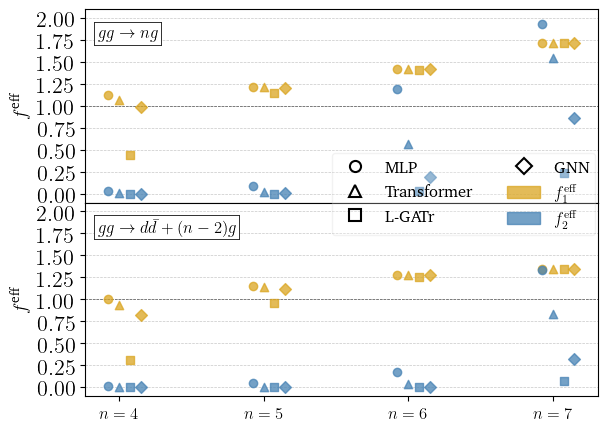

In [16]:
factors_colors = {
    "1": "goldenrod",
    "2": "steelblue",
}
with PdfPages("figs/new_dataset/regression/gain_factors-cpu-bothmethods.pdf") as pp:
    fig, axs = plt.subplots(
        2, 1, figsize=(1.0 * figsize[0], 1.0 * figsize[1]), sharex=True
    )
    fig.subplots_adjust(hspace=0, left=rect[0], bottom=0.1, right=0.99, top=rect[3])
    for i, (ax, dataset) in enumerate(zip(axs, datasets)):
        ax.axhline(
            1.0,
            color="black",
            linestyle="--",
            linewidth=0.5,
            zorder=1,
        )
        for n, net in enumerate(networks):
            f1 = np.array([gain_algorithm_1[p][net] for p in processes[dataset]])
            f2 = np.array([gain_algorithm_2[p][net] for p in processes[dataset]])
            x = np.arange(len(processes[dataset]))
            x_labels = [rf"$ n = {i + 4}$" for i in range(len(processes[dataset]))]
            xplot = x + 0.075 * (n - 1)  # Shift x for each subplot
            ax.scatter(
                xplot,
                f1,
                marker=network_markers[net],
                # linewidth = 0,
                color=factors_colors["1"],
                alpha=0.75,
                zorder=3,
            )
            ax.scatter(
                xplot,
                f2,
                marker=network_markers[net],
                # linewidth = 0,
                color=factors_colors["2"],
                alpha=0.75,
                zorder=4,
            )
            ax.text(
                0.025,
                0.85,
                rf"{datasets_names[dataset]}",
                transform=ax.transAxes,
                fontsize=12,
                ha="left",
                bbox=dict(
                    facecolor="white",  # box color
                    edgecolor="black",  # box border color
                    boxstyle="square,pad=0.2",
                    linewidth=0.5,
                    alpha=0.9,  # box opacity (optional)
                ),
            )
        ax.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.7, axis="y")
        ax.set_ylim(-0.1, 2.1)
        ax.set_yticks(np.arange(0, ax.get_ylim()[1], 0.25))
        ax.set_ylabel(r"$f^{\text{eff}}$", fontsize=14)
        if i != len(axs) - 1:
            ax.set_xticklabels([])
            # ax.set_xticks([])
        else:
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels, fontsize=12)
            # ax.set_xlabel("Number of particles $n$", fontsize=14)

    legend_networks = [
        plt.Line2D(
            [],
            [],
            marker=network_markers["MLP"],
            color="black",
            markerfacecolor="none",
            markeredgewidth=1.5,
            linestyle="None",
            markersize=8,
            label="MLP",
        ),
        plt.Line2D(
            [],
            [],
            marker=network_markers["Transformer"],
            color="black",
            markerfacecolor="none",
            markeredgewidth=1.5,
            linestyle="None",
            markersize=8,
            label="Transformer",
        ),
        plt.Line2D(
            [],
            [],
            marker=network_markers["LGATr"],
            color="black",
            markerfacecolor="none",
            markeredgewidth=1.5,
            linestyle="None",
            markersize=8,
            label="L-GATr",
        ),
        plt.Line2D(
            [],
            [],
            marker=network_markers["GNN"],
            color="black",
            markerfacecolor="none",
            markeredgewidth=1.5,
            linestyle="None",
            markersize=8,
            label="GNN",
        ),
    ]
    legend_factors = [
        Patch(
            color=factors_colors["1"],
            label=r"$f^{\mathrm{eff}}_1$",
            alpha=0.75,
        ),
        Patch(
            color=factors_colors["2"],
            label=r"$f^{\mathrm{eff}}_2$",
            alpha=0.75,
        ),
    ]
    combined_handles = legend_networks + legend_factors
    fig.legend(
        handles=combined_handles,
        loc="center right",
        frameon=True,
        ncols=2,
        fontsize=12,
        framealpha=0.25,
        bbox_to_anchor=(1.0, 0.55),
    )  # (x, y): move legend further right
    fig.savefig(pp, format="pdf")